### Load pre-trained data

In [1]:
%config Completer.use_jedi = False
### reload magic
%reload_ext autoreload
%autoreload 2
import numpy as np
# import pickle
from tqdm import tqdm
import os, sys, glob
from datetime import datetime
# import seaborn as sns

os.environ['ROOT_DATA_DIR']='/work/xc3vancechen/data/DLRA_database'
from utility import (load_data, count, performance, idxFromDatetime, get_all_qpf,
                     ratio_count, cal_itv_error, error_divided_by_season)
from plottingFunction import HSS_line_plot, CSI_line_plot, PFD_2D, CDF_2D, boxPlot, plotFig

sampling_rate=6

In [2]:
# load data
"""
path = "/work/dong1128/model_output/"
path = os.path.join(os.getcwd(), "repro_data")
fileList = [os.path.join(os.getcwd(), "repro_data", i) for i in sorted(os.listdir(path)) if "avg" in i]
"""
path = "/work/xc3vancechen/data/model_output/repro_data"
AllfileList = [os.path.join(path, fname) for fname in sorted(os.listdir(path)) if "mt" in fname]
fileList_tmp = sorted(AllfileList)
# model decision
# 1. For Architecture Exps
fileList = [fileList_tmp[1], fileList_tmp[2], fileList_tmp[-2], fileList_tmp[-1]]
names = ['All_LCL', 'PONI_All', 'PONI', 'CPN']
# 2. For Heterogeneous Exps
"""
fileList_Arc = [fileList_tmp[2],fileList_tmp[-2], fileList_tmp[-1]]
fileList_Heteo = fileList_tmp[3:8]

fileList = []
for hetvar in fileList_Heteo:
    fileList = fileList_Arc
    fileList.append(hetvar)

names = ['PONI_All', 'PONI', 'CPN', 'PONI_WTDOT', 'PONI_ThetaE', 'PONI_Season', 'PONI_Terrain', 'PONI_Wind']
"""

print(fileList)

['/work/xc3vancechen/data/model_output/repro_data/BalGRUAdvPONI_addponi_mt18_dt127_lcl-1_v-19_hourly_2022.pkl', '/work/xc3vancechen/data/model_output/repro_data/BalGRUAdvPONI_addponi_mt18_dt127_v-2_hourly_2022.pkl', '/work/xc3vancechen/data/model_output/repro_data/BalancedGRUAdvPONI_mt17_dt17_v-1_hourly_2022.pkl', '/work/xc3vancechen/data/model_output/repro_data/BalancedGRUAdverserial_mt6_dt17_v-0_hourly_2022.pkl']


In [3]:
data_loader = load_data(*fileList, file_num = len(fileList))
all_data, target, init_t, = data_loader._return

/work/xc3vancechen/data/model_output/repro_data/BalGRUAdvPONI_addponi_mt18_dt127_lcl-1_v-19_hourly_2022.pkl has been loaded.
/work/xc3vancechen/data/model_output/repro_data/BalGRUAdvPONI_addponi_mt18_dt127_v-2_hourly_2022.pkl has been loaded.
/work/xc3vancechen/data/model_output/repro_data/BalancedGRUAdvPONI_mt17_dt17_v-1_hourly_2022.pkl has been loaded.
/work/xc3vancechen/data/model_output/repro_data/BalancedGRUAdverserial_mt6_dt17_v-0_hourly_2022.pkl has been loaded.


In [ ]:
# idx_st_2022 = 23
# for nt in range(0,len(all_data)):
#     all_data[nt] = all_data[nt][idx_st_2022:,...]
# init_t = init_t[idx_st_2022:]
# target = target[idx_st_2022:,...]
print("data date:", init_t[0])

print("type of target:", type(target))
print("target shape:", target.shape)
print("the sum of target shape:", target.sum(axis=1).shape)

print("type of all data:", type(all_data))
print("all data shape:", all_data[0][:, 0].shape)
print("the sum of target shape:", all_data[0][:, 0].sum(axis=1).shape)

## Read QPESUMSQPF

In [ ]:
all_qpf = get_all_qpf(init_t)
all_data.append(all_qpf[:,None,...])
print(all_qpf.shape)

In [ ]:
print(len(all_data))
print(all_data[0].shape)
print((all_data[0].squeeze()).shape)
print((all_data[0][::,:,0].squeeze()).shape)
print(all_data[-1].shape)
print((all_data[-1].squeeze()).shape)
print((all_data[-1][::,:,0].squeeze()).shape)
print((target.squeeze()).shape)
print(init_t[0])
print(init_t[-1])

### calculate CSI score

In [ ]:
CSI_container = []
for d in tqdm(all_data, ncols=60):
    for t in range(3): # target_len
        verify_score = performance(d[::,:,t].squeeze(), target[::,t])
        CSI_container.append(verify_score._CSI[None])
CSI_score = np.split(np.concatenate(CSI_container, axis = 0), len(all_data)) # [N][3, 8]
# CSI_score = np.split(np.concatenate(CSI_container, axis = 0), 6) # [N][3, 8]
# count number
numbers = count(target[:,0])

### calculate CSI scores of first hour and 3h rainfall

In [4]:
CSI_container = []
for d in tqdm(all_data, ncols=60):
    for t in range(2): # target_len
        if t == 0:
            # first hour
            verify_score = performance(d[::,:,t].squeeze(), target[::,t])
            tmpCSI = verify_score._CSI
            tmpCSI[-2:] = np.nan
            CSI_container.append(tmpCSI[None])
        else:
            # 0-3h
            verify_score = performance(np.sum(d.squeeze(),axis=1), np.sum(target.squeeze(),axis=1))
            CSI_container.append(verify_score._CSI[None])
CSI_score = np.split(np.concatenate(CSI_container, axis = 0), len(all_data)) # [N][2, 10]
# count number
numbers = count(target[:,0])

  0%|                                 | 0/4 [00:00<?, ?it/s]

computing workers: 32
[(0.48934982160275603, 0.6383578376238737), (0.4465347696424472, 0.608014529482282), (0.42488397297170527, 0.5904434317950944), (0.3853063548708697, 0.5537326166233384), (0.346693122607388, 0.5135485910473908), (0.31152150269827106, 0.47428440317423864), (0.24542834622554463, 0.39383934231829976), (0.19317964811594496, 0.3236954958046249), (0.11096273921131637, 0.19974179574591444), (0.05478180129990715, 0.10387150889195267)]
computing workers: 32
[(0.345243285690986, 0.4453901870254876), (0.28589006942561124, 0.4002524788180806), (0.2612476222475151, 0.3818258112619966), (0.2392586153471429, 0.3686002598788142), (0.2380817621843271, 0.37410400233285807), (0.23744376846334006, 0.3769594533344353), (0.22451971404791912, 0.36333110915603084), (0.20595326361416297, 0.33967327213588044), (0.1596552345123936, 0.27464066126159553), (0.10118615175796408, 0.18358775290408852)]


 25%|██████                  | 1/4 [12:11<36:33, 731.24s/it]

computing workers: 32
[(0.482291064644203, 0.6312745550833765), (0.43563822228641175, 0.5970497767464422), (0.4153097872207932, 0.5806636215688833), (0.3842685329574214, 0.5525324726052131), (0.3523037582984638, 0.5196375129184284), (0.3202844520678388, 0.48435649023161104), (0.2607820870320053, 0.41337096914774574), (0.21398110105538345, 0.35240433758440537), (0.13207863335302988, 0.2333179927117742), (0.02447941503735495, 0.047787662312948447)]
computing workers: 32
[(0.3375242653592435, 0.4341909875385729), (0.292766024617994, 0.4089364065926332), (0.2723445515229746, 0.396429503547547), (0.2465112541098776, 0.37820098597043333), (0.23818254107664652, 0.37404057921975914), (0.23778946613442037, 0.37721094619180806), (0.24030399379863576, 0.3841290842570587), (0.23482057287219588, 0.3785357086147144), (0.20347454732691303, 0.33753520006215226), (0.1561437257394112, 0.26997748807702976)]


 50%|████████████            | 2/4 [24:20<24:20, 730.15s/it]

computing workers: 32
[(0.4680080302977251, 0.6169012454316823), (0.433306646493114, 0.5946948784536227), (0.41565824249755295, 0.5810481285049921), (0.38334726481514714, 0.5516262796619991), (0.3499570272484101, 0.5171121206623405), (0.31600268601666853, 0.47946440697169784), (0.24869116178005857, 0.39803450299714804), (0.19330099007200524, 0.3238676418656638), (0.10908780353567464, 0.1967001811964378), (0.022963819593589955, 0.04489570503457073)]
computing workers: 32
[(0.25706708854327026, 0.31657010312746003), (0.2430047606933378, 0.3393397342331216), (0.24015052278587268, 0.3522450387835438), (0.2390533054381869, 0.368252766493707), (0.24473637824994596, 0.38291496400578245), (0.24963202019830727, 0.39294038035017764), (0.24976395592151718, 0.3965607879197048), (0.23872407990885053, 0.3837462512839452), (0.20474791901571932, 0.339325212848735), (0.14779005079935703, 0.2573917421459468)]


 75%|██████████████████      | 3/4 [36:30<12:09, 729.85s/it]

computing workers: 32
[(0.46143631715974903, 0.6101346285284657), (0.4264421085746229, 0.5877679778622269), (0.4126142543242692, 0.578002171644842), (0.38041173345551804, 0.5485803200793836), (0.34308806800135566, 0.509558876251369), (0.3037619232859655, 0.46521330226114177), (0.23153176548384116, 0.37572850450549383), (0.17411000402752727, 0.29647737788869033), (0.09152014545735894, 0.16767846934598096), (0.024517212426532327, 0.04786022109270589)]
computing workers: 32
[(0.28887818258967, 0.36523734557093573), (0.25014546636452945, 0.349770361942008), (0.24011641564412708, 0.3523063090210853), (0.22799164256796742, 0.3532153292639108), (0.2284960468682184, 0.36122634674054827), (0.2324620429726302, 0.37035062349977116), (0.23091335449653372, 0.3719247268644846), (0.21762960228018485, 0.3557062755915899), (0.16725432249056613, 0.28595268521143113), (0.10350135494693892, 0.18744412810638408)]


100%|████████████████████████| 4/4 [48:40<00:00, 730.01s/it]


In [ ]:
print(CSI_score[0].shape)
print(len(CSI_score))

In [5]:
import pickle
dest_path = os.path.join('/work/xc3vancechen/data/statics/CSI', 'Architecture_Heteo_exps_CSIs_2022.pkl')
with open(dest_path, 'wb') as handle:
    pickle.dump([CSI_score, numbers], handle, protocol=pickle.HIGHEST_PROTOCOL)

# static_paths = '/work/xc3vancechen/data/statics/CSI/'
# exp_path = [os.path.join(static_paths, fname) for fname in sorted(os.listdir(static_paths)) if "Architecture_Heteo" in fname]

# for exp in exp_path:
#     with open(exp, 'rb') as sf:
#         CSI_exps, numbers = pickle.load(sf)
#         print(exp)

# CSI_score = []
# for CSI_exp in CSI_exps:
#     CSI_score.append(CSI_exp)
# print(len(CSI_score))

In [ ]:
# Caculate improvement percentage
print(CSI_score[0].shape)
CSI_1h_All = []
for nmt in CSI_score:
    tmp_CSI_1h = np.mean(nmt, axis=(0,1))
    CSI_1h_All.append(tmp_CSI_1h)

counter = 0
for kk in CSI_1h_All:
    print('Improvements of '+ names[counter] +':', (CSI_1h_All[counter]-CSI_1h_All[-1])/CSI_1h_All[-1]*100,'%')
    counter += 1

### plot

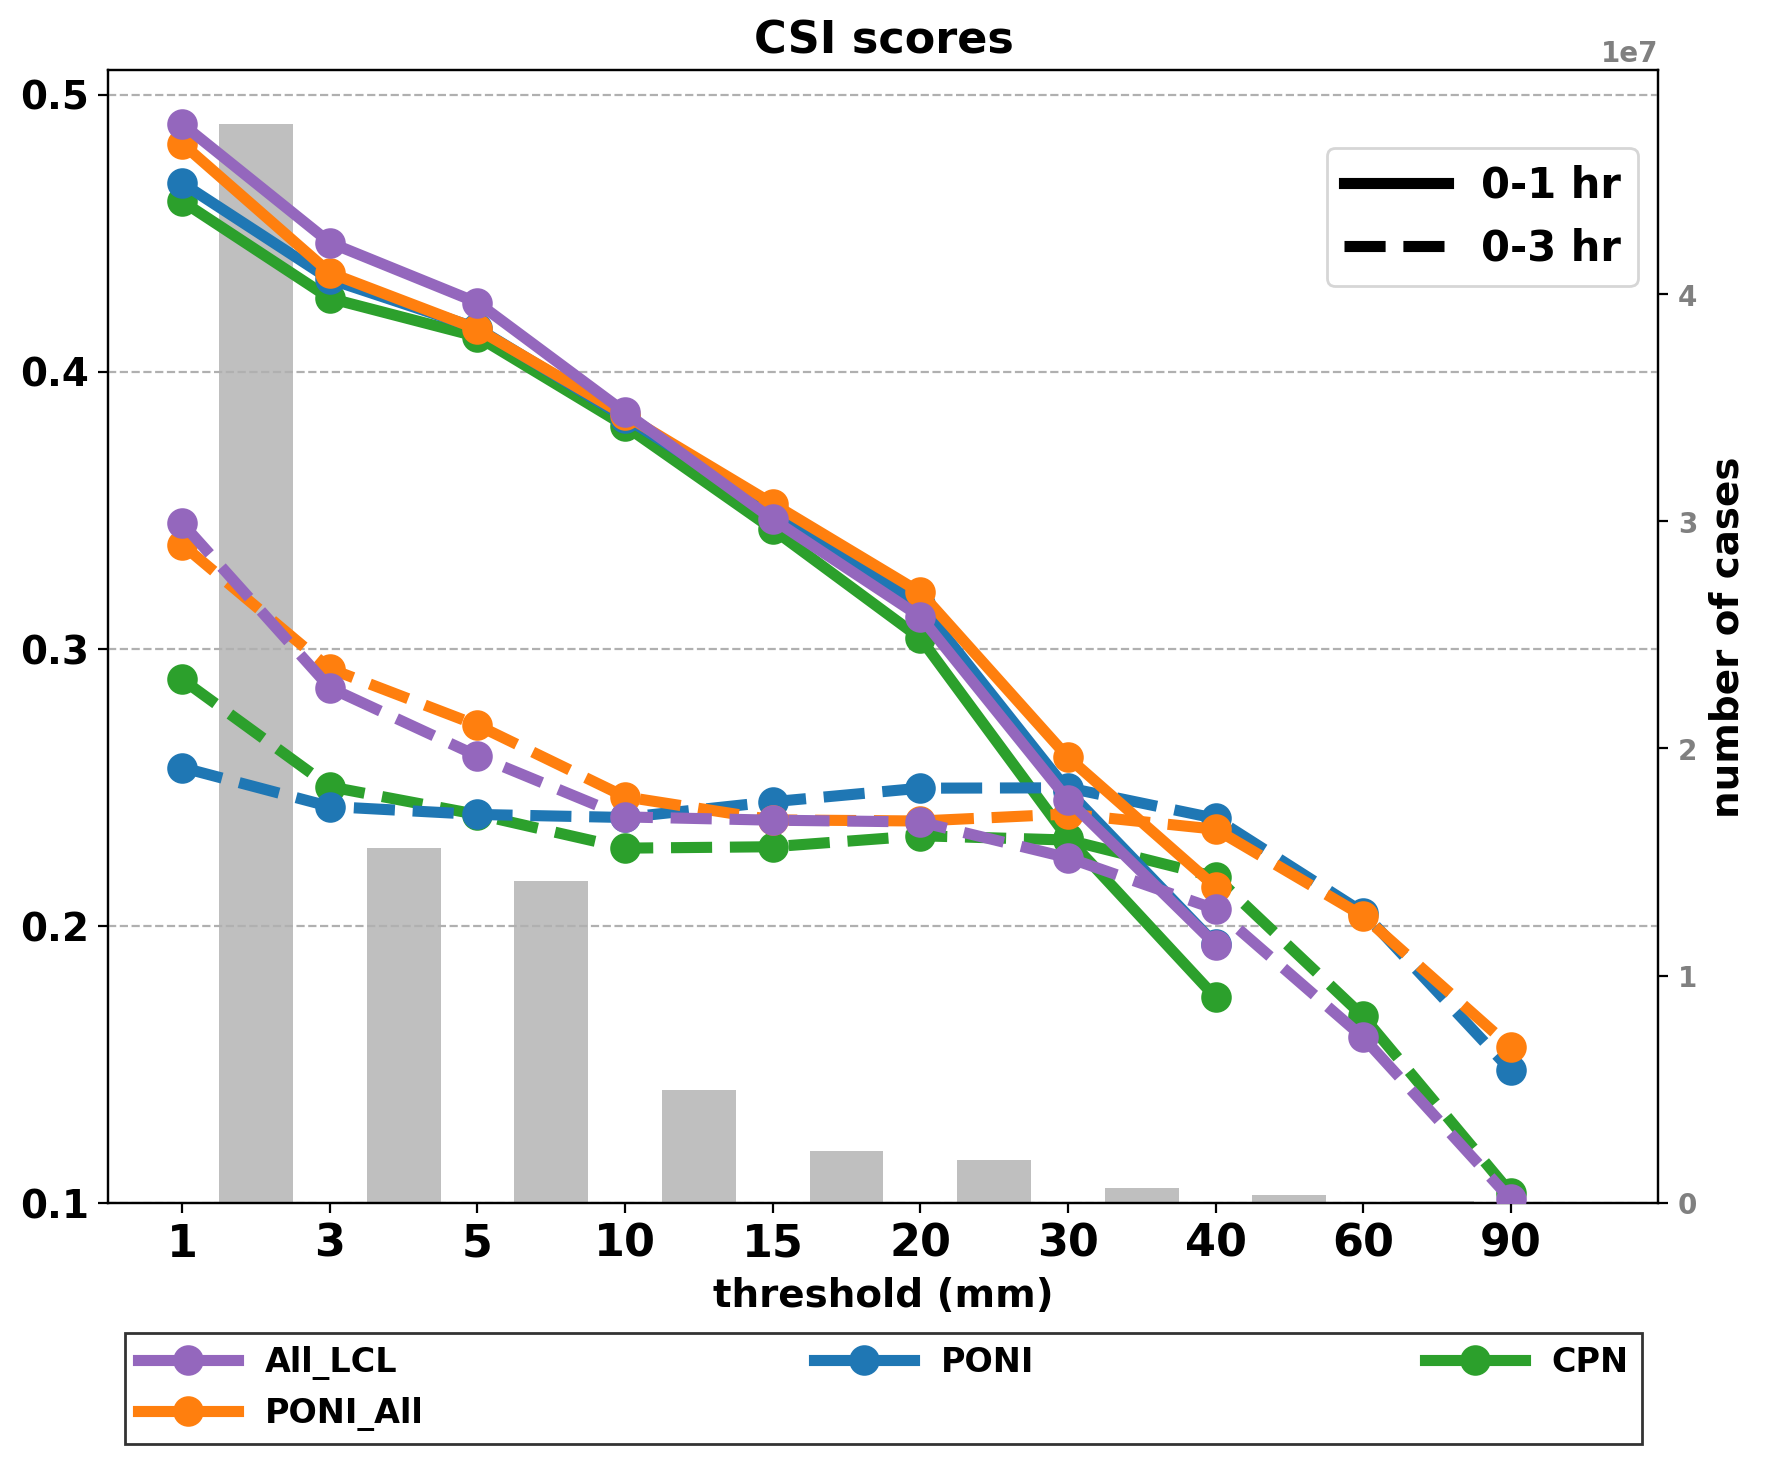

In [6]:
# HSS_line_plot(names, *CSI_score, numbers=numbers, colors = ['C3', 'C4', 'C1', 'C0', 'C2', 'k', 'C5'])
CSI_line_plot(names, *CSI_score, numbers=numbers, colors = ['C4', 'C1', 'C0', 'C2', 'C3', 'k', 'C5'], target_len=2)
# CSI_line_plot(names, *CSI_score, numbers=numbers, colors = ['C1', 'C0', 'C2', 'tan', 'C3', 'C8', 'C7', 'thistle'], target_len=2)

### performance diagram

In [ ]:
tar_t = 0 # 0 or 1 or 2
# preds = [x[:, 0, tar_t] for x in all_data]
# PFD_2D(preds, target[:, tar_t], thresholds = [1,3,5,10,15,20,30,40,50,60,70], names = names, colors=['C3', 'C1', 'C0', 'C2', 'C4', 'C6','k'])
# PFD_2D(preds, target[:, tar_t], thresholds = [1,5,10,15,20,30,40,60], names = names, colors=['C4', 'C1', 'C0', 'C2', 'C3', 'C6','k'])
''' 0-3 acum'''
# DL_data = [all_data[0], all_data[1], all_data[2]]
preds = [x[:, 0].sum(axis=1) for x in all_data]
PFD_2D(preds, target.sum(axis=1), thresholds = [10,20,40,60,90], names = names, colors=['C4', 'C1', 'C0', 'C2', 'C3', 'C6','k'])

### CDF plot

In [ ]:
preds = [x[:, 0].sum(axis=1) for x in all_data]
CDF_2D(preds, target.sum(axis=1), thresholds = [10,20,30,40,50,70,100], names = names, colors=['C3', 'C1', 'C0', 'C2', 'C4','k'])

### Ratio

In [ ]:
l = [0,1,3,5,8,10,15,20,25,30,35,40,45,50]
tar_t = 2 # 0 or 1 or 2
input_data = [x[:, 0, tar_t] for x in all_data]
ratios = ratio_count(input_data, target[:, tar_t], threshold = l).start() #[N][len(l)]

In [ ]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
COLORS = ['C9', 'C1', 'C2', 'C3', 'C4']
fig, ax = plt.subplots(1, 1, num='result', figsize=(7, 5.6), dpi=200, facecolor='w')
plt.plot(l,ratios[0],color="C9", alpha=0.6, zorder=5)
plt.fill_between(l, 0, ratios[0], facecolor="C9", alpha = 0.5, zorder=5)
for i in range(1, len(ratios)):
    plt.plot(l,ratios[i],color="C"+str(i), alpha=0.6)
    plt.fill_between(l, 0, ratios[i], facecolor="C"+str(i), alpha = 0.5)
ax.set_xlim(0, 50)
ax.set_xticks(np.arange(0,55,5))
ax.set_xticklabels(np.arange(0,55,5),fontsize=10)
# ax.set_yticks(np.arange(0,3,0.5)) # 0-1
# ax.set_ylim(bottom=0, top=2.5)
# ax.set_yticks(np.arange(0, 8)) # 1-2
# ax.set_ylim(bottom=0, top=7)
ax.set_yticks(np.arange(0,13)) # 2-3
ax.set_ylim(bottom=0, top=12)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(a) for a in vals],fontsize=10)
ax.grid(zorder=-2,alpha=0.4)
handles = [
    Patch(facecolor=color, label=label, alpha=0.7) 
    for label, color in zip(names, COLORS)
]
ax.legend(handles=handles, edgecolor='black',fontsize=10)

### Box error

In [10]:
tar_t = 0 # 0 or 1 or 2
# data_for_error = [x[:, 0, tar_t] for x in all_data]
# target_for_error = target[:,tar_t] # [B, H, W]
# bias = cal_itv_error(data_for_error, target_for_error, [0,1,3,5,10,15,20,30,40])
# ticks_name = ['0~1', '1~3', '3~5', '5~10', '10~15', '15~20', '20~30', '30~40', '>= 40']
''' 3-h accu '''
data_for_error = [x[:, 0].sum(axis=1) for x in all_data]
target_for_error = target.sum(axis=1) # [B, H, W]
bias = cal_itv_error(data_for_error, target_for_error, [0,10,30,50,70,100,130,200])
ticks_name = ['0~10 mm', '10~30', '30~50', '50~70', '70~100', '100~130', '>=130'] # not plot >200mm

100%|████████████████████████| 4/4 [09:01<00:00, 135.35s/it]


In [ ]:
#print(data_for_error[0][0:3,...].shape)
#x, y, z = np.where((np.isnan(data_for_error[0][0:3,...])==False))
#x, y, z = np.where((np.isnan(data_for_error[0][0:3,...])==False) & (target[0]>=1))
#print(x.shape[0]/np.size(target[0]))

100%|█████████████████████████| 4/4 [03:17<00:00, 49.42s/it]


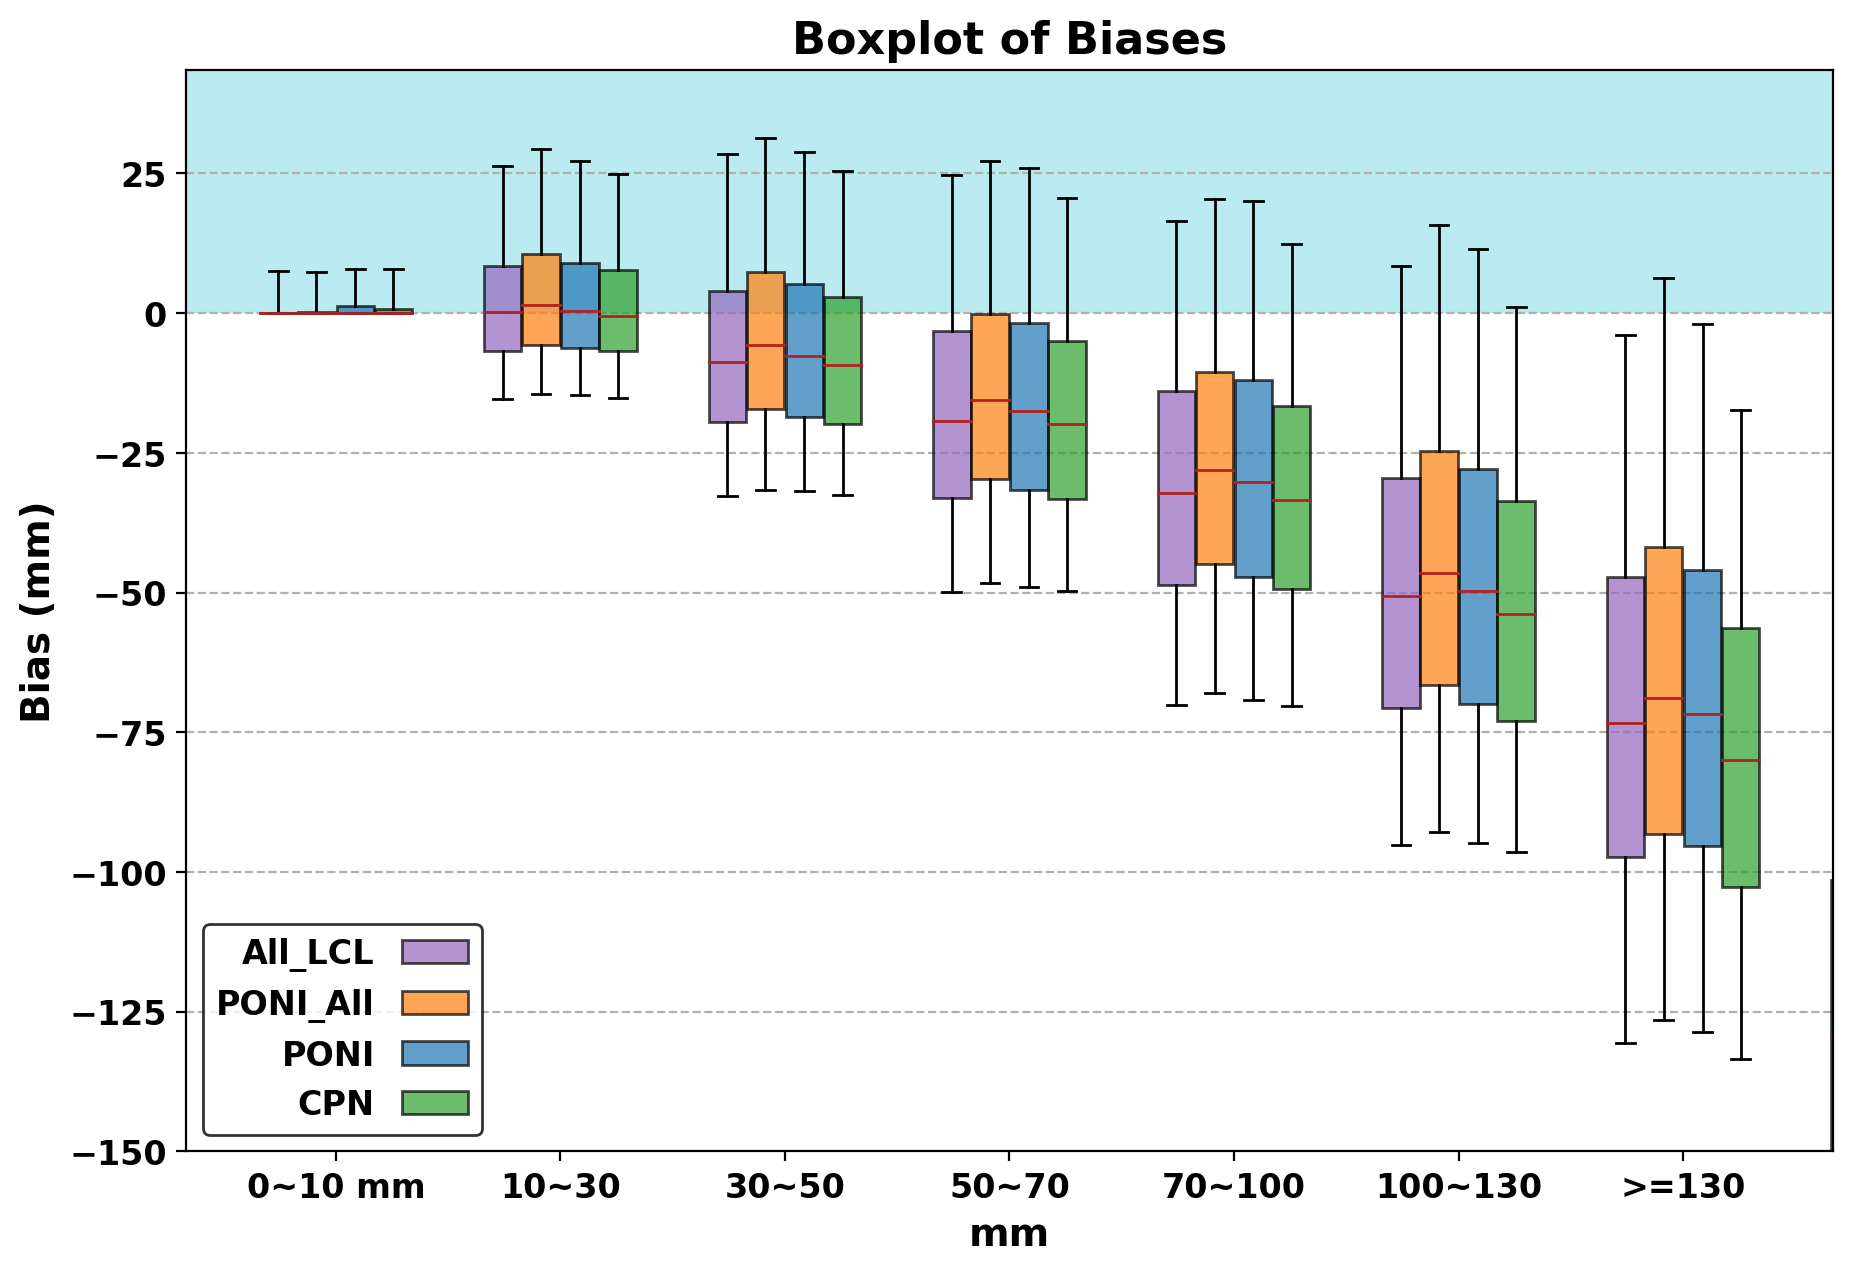

In [11]:
boxPlot(bias, names, ticks_name, colors = ['C4', 'C1', 'C0', 'C2', 'C3', 'k', 'C5'])

### Season check

In [ ]:
tar_t = 0 # 0 or 1 or 2
# data_for_season = [x[:, 0, tar_t] for x in [all_data[0], all_data[1]]]
# target_for_season = target[:,tar_t] # [B, H, W]
# bias_season = error_divided_by_season(data_for_season, target_for_season, init_t, [0,1,3,5,10,15,20,30,40])\
#                    .cal_error()
''' 3 hr '''
data_for_season = [x[:, 0].sum(axis=1) for x in [all_data[0], all_data[1]]]
target_for_season = target.sum(axis=1) # [B, H, W]
bias_season = error_divided_by_season(data_for_season, target_for_season, init_t, [0,10,30,50,70,100,130,200])\
                   .cal_error()

In [ ]:
names_season = ['PONI(summer)', 'PONI(winter)', 'Wind(summer)', 'Wind(winter)']
# ticks_name = ['0~1', '1~3', '3~5', '5~10', '10~15', '15~20', '20~30', '30~40', '>= 40']
ticks_name = ['0~10 mm', '10~30', '30~50', '50~70', '70~100', '100~130', '>=130'] # not plot >200mm
boxPlot(bias_season, names_season, ticks_name)

### Simple verification

In [ ]:
### settings
# 2018/5/7 16:10 鋒面
# 2019/5/28 5:10~13:00 LST front case
# 2019/5/20 8:00 LST chimney cloud
# 2019/7/22 13:00 LST ATS
# 2019/9/30 9:50 TC. Mitag
# 2019/12/30 23:00 東北季風
# 2021/6/4 3:10 台北暴雨
# 2021/10/16 5:10 虎豹潭事件

# rainfall event
idx = idxFromDatetime(init_t, datetime(2021,6,4,3,10))
# idx = idxFromDatetime(init_t, datetime(2021,10,16,5,10))
# idx = idxFromDatetime(init_t, datetime(2019,9,30,9,50))
backoff_num = int((6 / sampling_rate) * 2)
event = np.concatenate([target[idx-backoff_num:idx+8, 0:1], all_data[2].squeeze()[idx-backoff_num:idx+8]], axis=1)
plotFig(init_t[idx:idx+8], event, backoff_num)